In [75]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense,Input,Normalization
from tensorflow.keras import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.activations import sigmoid,relu
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [76]:
def my_sigmoid(z):
  tmp=1/(1+np.exp(-z))
  return tmp

In [77]:
def my_softmax(z):
  ez=np.exp(z)
  sm=ez/np.sum(ez)
  return sm

In [78]:
def my_relu(z):
  tmp=z>0
  ans=tmp*z
  return ans

In [79]:
def my_linear(z):
  return z

In [80]:
def my_dense_linear(a_in,w,b):
  z=np.matmul(a_in,w)+b
  a_out=my_linear(z)
  return a_out

In [81]:
def my_dense_relu(a_in,w,b):
  z=np.matmul(a_in,w)+b
  a_out=my_relu(z)
  return a_out

In [82]:
def my_sequential(x,w1,b1,w2,b2,w3,b3):
  a1=my_dense_relu(x,w1,b1)
  a2=my_dense_relu(a1,w2,b2)
  a3=my_dense_linear(a2,w3,b3)
  return(a3)

In [83]:
def my_predict(x,w1,b1,w2,b2,w3,b3):
  m=x.shape[0]
  p=[]
  for i in range(m):
    p.append(my_sequential(x[i],w1,b1,w2,b2,w3,b3))
  return p

In [84]:
# Using these functions we can make inferences if we are given weights for each layer
# Now we will user tensorflow to train custom model and we can also use weights from that model in our custom functions to make inferences

In [85]:
df=pd.read_csv('customer.csv')

In [86]:
print(df.head())

       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  462643  Female          Yes   38       Yes       Engineer              NaN   
2  466315  Female          Yes   67       Yes       Engineer              1.0   
3  461735    Male          Yes   67       Yes         Lawyer              0.0   
4  462669  Female          Yes   40       Yes  Entertainment              NaN   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1        Average          3.0  Cat_4            A  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B  
4           High          6.0  Cat_6            A  


In [87]:
df = df.dropna()
le=LabelEncoder()
df["Gender"]=le.fit_transform(df["Gender"])
df["Ever_Married"]=le.fit_transform(df["Ever_Married"])
df["Graduated"]=le.fit_transform(df["Graduated"])
df=pd.get_dummies(df,columns=["Profession","Spending_Score"])
print(df)

          ID  Gender  Ever_Married  Age  Graduated  Work_Experience  \
0     462809       1             0   22          0              1.0   
2     466315       0             1   67          1              1.0   
3     461735       1             1   67          1              0.0   
5     461319       1             1   56          0              0.0   
6     460156       1             0   32          1              1.0   
...      ...     ...           ...  ...        ...              ...   
8062  463002       1             1   41          1              0.0   
8064  464685       1             0   35          0              3.0   
8065  465406       0             0   33          1              1.0   
8066  467299       0             0   27          1              1.0   
8067  461879       1             1   37          1              0.0   

      Family_Size  Var_1 Segmentation  Profession_Artist  ...  \
0             4.0  Cat_4            D                  0  ...   
2             1.0

In [88]:
features = [x for x in df.columns if x not in 'ID' and x not in 'Var_1' and x not in 'Segmentation']
# y=pd.get_dummies(df,columns=["Segmentation"])
# features_y=[x for x in y.columns if x in 'Segmentation_A' or x in 'Segmentation_B' or x in 'Segmentation_C' or x in 'Segmentation_D']
df.loc[df["Segmentation"] == "A", "Segmentation"] = 0
df.loc[df["Segmentation"] == "B", "Segmentation"] = 1
df.loc[df["Segmentation"] == "C", "Segmentation"] = 2
df.loc[df["Segmentation"] == "D", "Segmentation"] = 3

x_train, x_, y_train, y_ = train_test_split(df[features], df['Segmentation'], train_size = 0.6, random_state = 50)
x_val, x_test, y_val, y_test = train_test_split(x_, y_, train_size = 0.5, random_state = 50)

In [89]:
norm_l=Normalization(axis=-1)
norm_l.adapt(x_train)
x_train_norm=norm_l(x_train)

norm_l.adapt(x_val)
x_val_norm=norm_l(x_val)

In [90]:
accuracy_val_list=[]
lambda_=[0,0.00001,0.0001,0.001,0.01,0.1,1,10,100]
# lambda_=[0.001]

for i in lambda_:

  model=Sequential(
      [
          Input(shape=(18,)),
          Dense(units=120,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(i)),
          Dense(units=40,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(i)),
          Dense(units=4,activation='linear')
      ],name="custom_model"
  )
  model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(0.01),
  )
  y_train = tf.convert_to_tensor(y_train, dtype = tf.int32)
  model.fit(
    x_train_norm,y_train,
    epochs=100
  )
  prediction=model.predict(x_val_norm)
  prediction_prob=tf.nn.softmax(prediction).numpy()
  n=prediction_prob.shape[0]
  y_hat=np.zeros(n)
  for j in range(n):
    y_hat[j]=np.argmax(prediction_prob[j])
  accuracy_val=np.mean(y_hat==y_val)

  prediction=model.predict(x_train_norm)
  prediction_prob=tf.nn.softmax(prediction).numpy()
  n=prediction_prob.shape[0]
  y_hat=np.zeros(n)
  for j in range(n):
    y_hat[j]=np.argmax(prediction_prob[j])
  accuracy_train=np.mean(y_hat==y_train)
  print(f"\n\nFor lambda={i} the accuracy on training set is {accuracy_train}")
  print(f"For lambda={i} the accuracy on validation set is {accuracy_val}\n\n\n\n\n")
  accuracy_val_list.append(accuracy_val)

Epoch 1/100
125/125 [==============================] - 1s 2ms/step - loss: 1.1384
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0882
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0764
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0582
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0460
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0470
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0308
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0368
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0286
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0089
Epoch 11/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0138
Epoch 12/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0036
Epoch 13/100


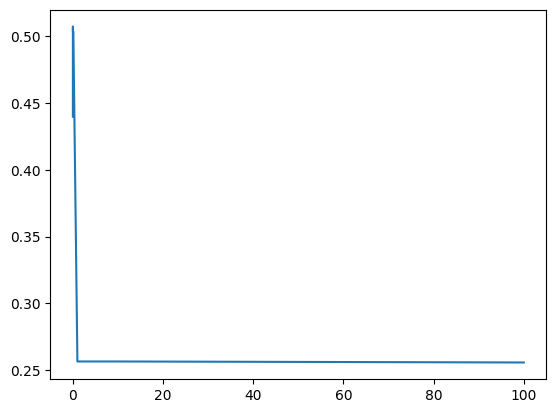

In [91]:
plt.plot(lambda_,accuracy_val_list)
plt.show()

In [92]:
lambda_opt=lambda_[np.argmax(accuracy_val_list)]
print(lambda_opt)

0.001


In [93]:
model=Sequential(
      [
          Input(shape=(18,)),
          Dense(units=120,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lambda_opt)),
          Dense(units=40,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lambda_opt)),
          Dense(units=4,activation='linear')
      ],name="custom_model"
  )
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer=Adam(0.01),
)
model.fit(
  x_train_norm,y_train,
  epochs=100
)
norm_l.adapt(x_test)
x_test_norm=norm_l(x_test)

prediction=model.predict(x_test_norm)
prediction_prob=tf.nn.softmax(prediction).numpy()
n=prediction_prob.shape[0]
y_hat=np.zeros(n)
for j in range(n):
  y_hat[j]=np.argmax(prediction_prob[j])
accuracy_test=np.mean(y_hat==y_test)
print(f"For lambda={lambda_opt} the accuracy on test set is {accuracy_test}\n\n\n\n\n")

Epoch 1/100
125/125 [==============================] - 1s 2ms/step - loss: 1.2148
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 1.1414
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 1.1195
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 1.1109
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 1.1067
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 1.1014
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0922
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0930
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0877
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0796
Epoch 11/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0838
Epoch 12/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0820
Epoch 13/100


In [94]:
[layer1,layer2,layer3]=model.layers
w1,b1=layer1.get_weights()
w2,b2=layer2.get_weights()
w3,b3=layer3.get_weights()

In [95]:
prediction=my_predict(x_test_norm,w1,b1,w2,b2,w3,b3)
y_hat=np.zeros(x_test_norm.shape[0])
for i in range(x_test_norm.shape[0]):
  y_hat[i]=np.argmax(prediction[i])
accuracy_test=np.mean(y_hat==y_test)
print(f"Accuracy on test set is {accuracy_test}")
print(f"So here we carried out inference on our own network whose weights were set according to the weights obtained from training\na custom neural network and we observe that both the accuracies come out the same")

Accuracy on test set is 0.522880720180045
So here we carried out inference on our own network whose weights were set according to the weights obtained from training
a custom neural network and we observe that both the accuracies come out the same
